# Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [2]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization
from keras.preprocessing import sequence

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.12.0


In [3]:
# Set seed for repeatable results
np.random.seed(123)
tf.set_random_seed(456)

## Data Processing

We have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [4]:
# Given code
path_dataset = 'NER_data.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
# list of unique words sorted in alphabetical order with "ENDPAD" appended
words = np.sort(data.Word.unique()).tolist()
words.append("ENDPAD") 
# count of unique words
n_words = len(words)

In [6]:
# list of unique words sorted in alphabetical order with "ENDPAD" appended
tags = np.sort(data.Tag.unique()).tolist()
tags.append("PAD")
# count of unique words
n_tags = len(tags)

In [7]:
# Process data into a list of sentences, each sentence is a list of (word, tag) tuples
sentence_lst = []
grouped = data.groupby('Sentence #')
for name, group in grouped:
    sentence_lst.append(list(zip(group['Word'], group['Tag'])))

In [8]:
max_len=data['Sentence #'].value_counts().max()

In [9]:
# Run this cell to show your results #
print(max_len)

104


In [10]:
# print first 2 sentences as 'word, tag' tuple
for i in range(len(sentence_lst[0:2])):
    print(sentence_lst[i])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
[('Iranian', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('they', 'O'), ('expect', 'O'), ('to', 'O'), ('get', 'O'), ('access', 'O'), ('to', 'O'), ('sealed', 'O'), ('sensitive', 'O'), ('parts', 'O'), ('of', 'O'), ('the', 'O'), ('plant', 'O'), ('Wednesday', 'B-tim'), (',', 'O'), ('after', 'O'), ('an', 'O'), ('IAEA', 'B-org'), ('surveillance', 'O'), ('system', 'O'), ('begins', 'O'), ('functioning', 'O'), ('.', 'O')]


In [11]:
# create word2idx and idx2word dictionaries with mapping distinct words to integers
word2idx = {}
idx2word = {}
for i, item in enumerate(words):
    word2idx[item] = i
    idx2word[i] = item  

In [12]:
data['word_idx']=data['Word'].map(word2idx)
lst1=data.groupby('Sentence #')['word_idx'].apply(list)
lst2=lst1.tolist()

In [13]:
word2idx['ENDPAD']

35178

In [14]:
X = sequence.pad_sequences(lst2, maxlen=max_len,padding='post',value=word2idx['ENDPAD'])

In [15]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [16]:
tag2idx = {}
idx2tag = {}
for i, item in enumerate(tags):
    tag2idx[item] = i
    idx2tag[i] = item

In [17]:
data['tag_idx']=data['Tag'].map(tag2idx)
tag_lst1=data.groupby('Sentence #')['tag_idx'].apply(list)
tag_lst2=tag_lst1.tolist()

In [18]:
y_org = sequence.pad_sequences(tag_lst2, maxlen=max_len,padding='post',value=tag2idx['PAD'])

In [19]:
y=to_categorical(y_org)

In [20]:
tag2idx['PAD']

17

In [21]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


In [22]:
# Split Train n test data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.1)

In [23]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [24]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

### Baseline Model ###

With baseline model we predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate"


In [40]:
y_tr1=np.argmax(y_tr, axis=-1)
y_te1=np.argmax(y_te, axis=-1)

X_tr1=X_tr.ravel()
y_tr1=y_tr1.ravel()
X_tr1.shape, y_tr1.shape

((4488952,), (4488952,))

In [41]:
baseline_tr=pd.DataFrame({'word_idx':X_tr1, 'tag_idx' : y_tr1})
freq=baseline_tr.groupby(['word_idx','tag_idx']).size().sort_values().groupby(level=0).tail(1)
baseline=freq.to_frame()
baseline.reset_index(inplace=True)

word_indx=pd.DataFrame({'word_idx' : [i for i in range(n_words)]})  #set baseline to length of n_words
# merge to have the baseline length equal to n_words
baseline=pd.merge(word_indx, baseline[['word_idx', 'tag_idx']], how='left', on='word_idx')

baseline.fillna(tag2idx['O'],inplace=True)  #for missing tags in train, replace tag as 'O'
baseline.set_index('word_idx',inplace=True)
baseline=baseline.values  #convert from dataframe to numpy array


In [42]:
print(idx2word[15077])
chk = baseline[15077][0]
print(chk)
print("Most frequently occured tag for word ",idx2word[15077], " is", idx2tag[chk])

Thousands
16.0
Most frequently occured tag for word  Thousands  is O


In [43]:
# Run this cell to show your results #

print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[baseline[i][0]] for i in X[0]]))
# print('Predicted Tags:\n {}'.format([idx2tag[i] for i in np.argmax(baseline[X[0]],axis=-1)]))
# print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104, 1) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'E

### Model 2: Vanilla Feed Forward Neural Network ###


In [27]:
# Hyper parameters
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [36]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [37]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 25s 646us/step - loss: 0.3246 - acc: 0.9774 - val_loss: 0.0604 - val_acc: 0.9858
Epoch 2/10
38846/38846 [==============================] - 24s 621us/step - loss: 0.0515 - acc: 0.9863 - val_loss: 0.0477 - val_acc: 0.9869
Epoch 3/10
38846/38846 [==============================] - 24s 631us/step - loss: 0.0451 - acc: 0.9872 - val_loss: 0.0448 - val_acc: 0.9875
Epoch 4/10
38846/38846 [==============================] - 24s 621us/step - loss: 0.0428 - acc: 0.9878 - val_loss: 0.0435 - val_acc: 0.9877
Epoch 5/10
38846/38846 [==============================] - 25s 637us/step - loss: 0.0414 - acc: 0.9881 - val_loss: 0.0428 - val_acc: 0.9880
Epoch 6/10
38846/38846 [==============================] - 24s 619us/step - loss: 0.0406 - acc: 0.9883 - val_loss: 0.0422 - val_acc: 0.9882
Epoch 7/10
38846/38846 [==============================] - 24s 626us/step - loss: 0.0401 - acc: 0.9885 - val_loss: 0.0

In [41]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


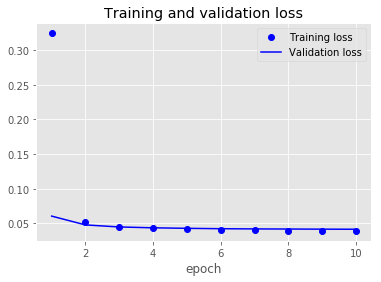

In [42]:
plot_training_history(history)

In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that these codes and parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [34]:
FFNN=load_keras_model('model_FFNN')

In [35]:
def create_truncated_model_FFNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_test=y_te.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9344486527075765


In [25]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features_BI(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        ax1.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax1.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  

    for cat in range(8,16):
        indices_I = np.where(category==cat)[0]
        ax2.scatter(pca_result[indices_I,0], pca_result[indices_I, 1], label=idx2tag[cat],s=2,color=color[cat-8],alpha=0.5)
        legend=ax2.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
        
    plt.show()

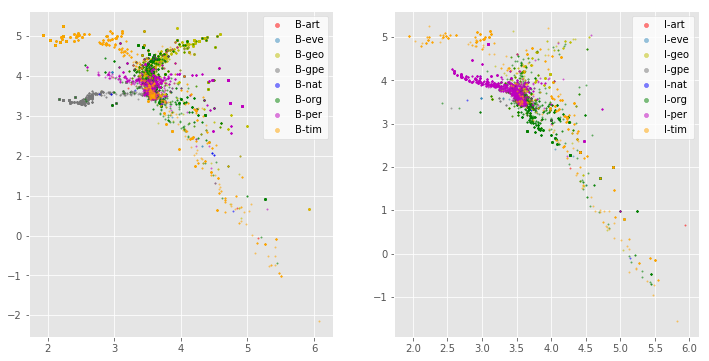

In [61]:
visualize_hidden_features_BI(pca_result)

## RNN

In [47]:
# your code #
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(n_units, return_sequences=True))
#model.add(TimeDistributed(Dense(8), input_shape=(5, 5)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [48]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 84s 2ms/step - loss: 0.0910 - acc: 0.9776 - val_loss: 0.0322 - val_acc: 0.9905
Epoch 2/10
38846/38846 [==============================] - 84s 2ms/step - loss: 0.0295 - acc: 0.9912 - val_loss: 0.0286 - val_acc: 0.9913
Epoch 3/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0261 - acc: 0.9921 - val_loss: 0.0275 - val_acc: 0.9919
Epoch 4/10
38846/38846 [==============================] - 83s 2ms/step - loss: 0.0244 - acc: 0.9927 - val_loss: 0.0270 - val_acc: 0.9920
Epoch 5/10
38846/38846 [==============================] - 84s 2ms/step - loss: 0.0232 - acc: 0.9931 - val_loss: 0.0267 - val_acc: 0.9921
Epoch 6/10
38846/38846 [==============================] - 84s 2ms/step - loss: 0.0222 - acc: 0.9934 - val_loss: 0.0264 - val_acc: 0.9921
Epoch 7/10
38846/38846 [==============================] - 85s 2ms/step - loss: 0.0213 - acc: 0.9936 - val_loss: 0.0266 - val_acc:

In [50]:
# save your mode ##
store_keras_model(model, 'model_RNN')


Saved model to disk


In [51]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


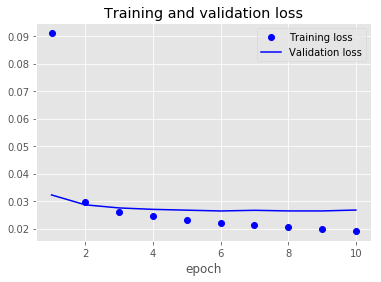

In [52]:
# run this cell to show your results #
plot_training_history(history)

#### Visualization of hidden features using PCA

In [53]:
# visualization of hidden features

RNN=load_keras_model('model_RNN')
truncated_model = create_truncated_model_FFNN(RNN)  #passing SimpleRNN to the truncated model definition

In [54]:
hidden_features = truncated_model.predict(X_te)
hidden_features=hidden_features.reshape(-1,50)

# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9814864586993796


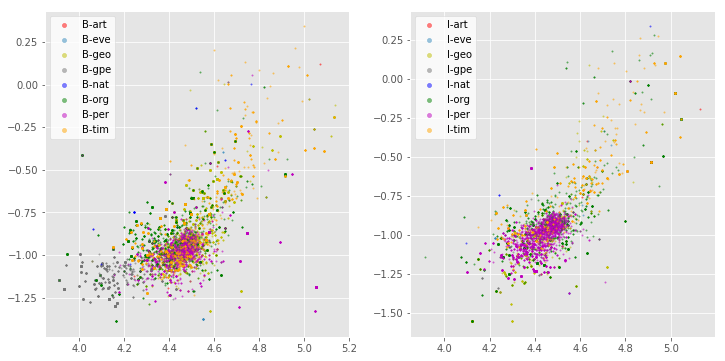

In [56]:
visualize_hidden_features_BI(pca_result)

<div class='explication'> </div>

### GRU ###

In [58]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(n_units, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [61]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 100)          45300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,068
Trainable params: 1,806,068
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 169s 4ms/step - loss: 0.0925 - acc: 0.9771 - val_loss: 0.0326 - val_acc: 0.9905
Epoch 2/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0291 - acc: 0.9914 - val_loss: 0.0284 - val_acc: 0.9916
Epoch 3/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0257 - acc: 0.9924 - val_loss: 0.0274 - val_acc: 0.9918
Epoch 4/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0240 - acc: 0.9929 - val_loss: 0.0261 - val_acc: 0.9922
Epoch 5/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0227 - acc: 0.9932 - val_loss: 0.0260 - val_acc: 0.9922
Epoch 6/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0216 - acc: 0.9935 - val_loss: 0.0259 - val_acc: 0.9923
Epoch 7/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0207 - acc: 0.9938 - val_loss: 0.0256 - v

In [60]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


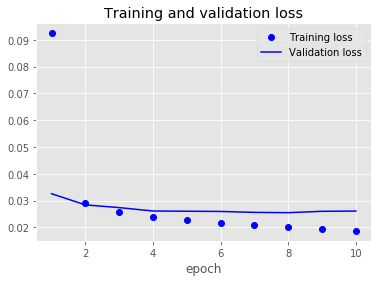

In [62]:
# run this cell to show your results #
plot_training_history(history)

In [63]:
# visualization of hidden features

GRU2=load_keras_model('model_GRU')
truncated_model = create_truncated_model_FFNN(GRU2)

In [67]:
hidden_features = truncated_model.predict(X_te)
hidden_features=hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.968354934413161


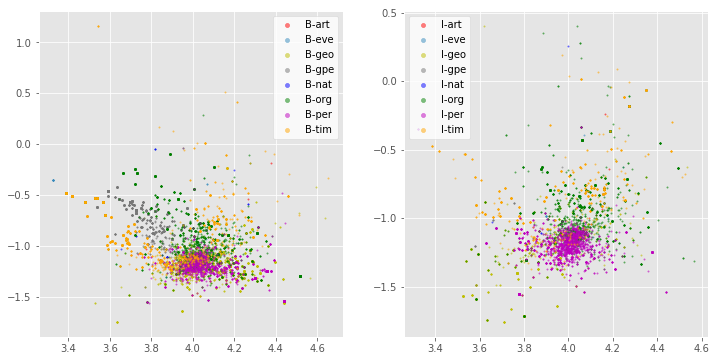

In [69]:
visualize_hidden_features_BI(pca_result)

<div class='explication'> </div>

**Visualize outputs from GRU layer, one subplot for B-tags and one subplot for I-tags,comment on the patterns you observed** 
<br>
From the GRU layer, we notice a little more separation of tags than the simpleRNN.Tags are cluttered at one point for both B-tags and I-tags, but we see that tags are separating out in different directions from that point.
<br>
In B-tags, we see 4 different tags well separated. They are 'B-per'(purple), 'B-tim'(orange), 'B-gpe'(greyish), 'B-org'(green) tags.<br>
With I-tags, there is slightly less separation. We see 'I-tim'(orange), 'I-org'(green) are more spread out more than the other tags.

### Bidirectional GRU ###

In [28]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(n_units, return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 381s 10ms/step - loss: 0.0744 - acc: 0.9816 - val_loss: 0.0280 - val_acc: 0.9919
Epoch 2/10
38846/38846 [==============================] - 378s 10ms/step - loss: 0.0246 - acc: 0.9928 - val_loss: 0.0243 - val_acc: 0.9929
Epoch 3/10
38846/38846 [==============================] - 374s 10ms/step - loss: 0.0211 - acc: 0.9938 - val_loss: 0.0230 - val_acc: 0.9931
Epoch 4/10
38846/38846 [==============================] - 370s 10ms/step - loss: 0.0192 - acc: 0.9943 - val_loss: 0.0228 - val_acc: 0.9933
Epoch 5/10
38846/38846 [==============================] - 372s 10ms/step - loss: 0.0179 - acc: 0.9947 - val_loss: 0.0219 - val_acc: 0.9934
Epoch 6/10
38846/38846 [==============================] - 372s 10ms/step - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0219 - val_acc: 0.9935
Epoch 7/10
38846/38846 [==============================] - 371s 10ms/step - loss: 0.0157 - acc: 0.9953 - val_loss: 0.0

In [30]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


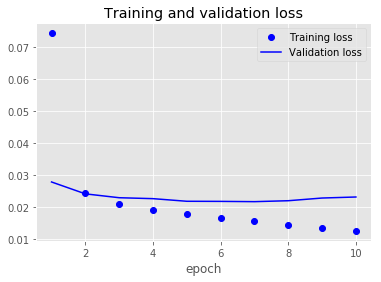

In [31]:
# run this cell to show your results #
plot_training_history(history)

Variance explained by PCA: 0.8255254042964156


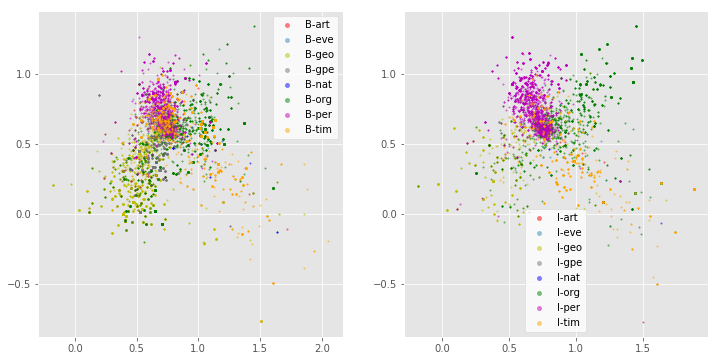

In [36]:
# visualization of hidden features

GRU2=load_keras_model('model_BiGRU')
truncated_model = create_truncated_model_FFNN(GRU2)

hidden_features = truncated_model.predict(X_te)
hidden_features=hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

visualize_hidden_features_BI(pca_result)

**Visualize outputs from Bidirectional GRU layer, one subplot for B-tags and one subplot for I-tags,comment on the patterns you observed** 
<br>
From the BiGRU layer, we notice a little more separation of tags than the simpleRNN or the GRU layer.
Tags are cluttered at one point for both B-tags and I-tags, but we see that tags are separating out in different directions from that point.
In B-tags, we see good separation for 'B-per'(purple) tags. 'B-tim'(orange) is slightly separated, and we some in combination with 'B-org'(green) tags.
With I-tags, there is less separation and visibility of all tags. We see distinct 'B-per'(purple) tags' with more instances. I-tim'(orange), 'I-org'(green) are slightly spread out.

## Evaluating models on Test data

In [37]:
y_test = y_te.reshape(-1, 18)
y_te.shape, y_test.shape

((4796, 104, 18), (498784, 18))

In [38]:
FFNN=load_keras_model('model_FFNN')
RNN=load_keras_model('model_RNN')
GRU2=load_keras_model('model_GRU')
BGRU=load_keras_model('model_BiGRU')

In [44]:
# prediction of f1 scorre on baseline model
y_pred = to_categorical(baseline[X_te]).reshape(-1,18)
# compute f1 score for FFNN model
f1_lst = f1_score(y_test, y_pred, average=None)
f1_lst = [np.round(elem,2) for elem in f1_lst]

df = pd.DataFrame({'TagName':[idx2tag[i] for i in range(n_tags)], 'Baseline':f1_lst})

models_=[FFNN,RNN,GRU2,BGRU]
col_names=['FFNN','RNN', 'GRU', 'BiGRU']
# predict on X for model FFNN
for i, val in enumerate(models_):
    y_pred = to_categorical(FFNN.predict_classes(X_te)).reshape(-1,18)
    # compute f1 score for FFNN model
    f1_lst = f1_score(y_test, y_pred, average=None)
    f1_lst = [np.round(elem,2) for elem in f1_lst]
    df[col_names[i]] = f1_lst

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## f1 scores for tags

In [45]:
# predict on X for model RNN
y_pred = to_categorical(RNN.predict_classes(X_te)).reshape(-1,18)
# compute f1 score for RNN model
f1_lst = f1_score(y_test, y_pred, average=None)
f1_lst = [np.round(elem,2) for elem in f1_lst]
df['Model_RNN'] = f1_lst

# predict on X for model GRU
y_pred = to_categorical(GRU2.predict_classes(X_te)).reshape(-1,18)
# compute f1 score for GRU model
f1_lst = f1_score(y_test, y_pred, average=None)
f1_lst = [np.round(elem,2) for elem in f1_lst]
df['Model_GRU'] = f1_lst

# predict on X for model Bidirectional GRU
y_pred = to_categorical(BGRU.predict_classes(X_te)).reshape(-1,18)
# compute f1 score for Bidirectional GRU model
f1_lst = f1_score(y_test, y_pred, average=None)
f1_lst = [np.round(elem,2) for elem in f1_lst]
df['Model_BGRU'] = f1_lst

print("f1 score for each tag and for each model")
df

f1 score for each tag and for each model


,TagName,Baseline,FFNN,RNN,GRU,BiGRU,Model_RNN,Model_GRU,Model_BGRU
0,B-art,0.26,0.14,0.14,0.14,0.14,0.15,0.13,0.03
1,B-eve,0.28,0.31,0.31,0.31,0.31,0.31,0.33,0.47
2,B-geo,0.83,0.81,0.81,0.81,0.81,0.85,0.86,0.88
3,B-gpe,0.94,0.93,0.93,0.93,0.93,0.94,0.95,0.95
4,B-nat,0.29,0.49,0.49,0.49,0.49,0.51,0.45,0.52
5,B-org,0.59,0.57,0.57,0.57,0.57,0.65,0.66,0.74
6,B-per,0.73,0.71,0.71,0.71,0.71,0.82,0.83,0.84
7,B-tim,0.82,0.79,0.79,0.79,0.79,0.86,0.86,0.89
8,I-art,0.06,0.00,0.00,0.00,0.00,0.12,0.00,0.00
9,I-eve,0.37,0.26,0.26,0.26,0.26,0.13,0.26,0.37


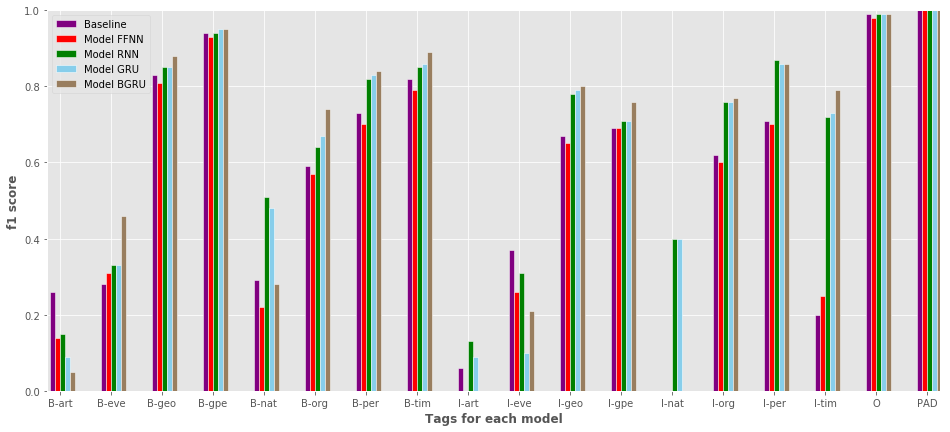

In [39]:
fig, ax = plt.subplots(figsize=(16,7))

# set width of bar
barWidth = 0.10
pos = list(range(len(df['TagName']))) 

# Set position of bar on X axis
r1 = np.arange(len(f1_lst))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


# Make the plot
plt.bar(r1, df['Baseline'], color='purple', width=barWidth, edgecolor='white', label='Baseline')
plt.bar(r2, df['Model_FFNN'], color='r', width=barWidth, edgecolor='white', label='Model FFNN')
plt.bar(r3, df['Model_RNN'], color='green', width=barWidth, edgecolor='white', label='Model RNN')
plt.bar(r4, df['Model_GRU'], color='skyblue', width=barWidth, edgecolor='white', label='Model GRU')
plt.bar(r5, df['Model_BGRU'], color='#997e5f', width=barWidth, edgecolor='white', label='Model BGRU')
 
# Add xticks on the middle of the group bars
ax.set_xlabel('Tags for each model', fontweight='bold')
ax.set_ylabel('f1 score', fontweight='bold')
# Set the position of the x ticks
ax.set_xticks([p + 1.5 * barWidth for p in pos])
# Set the labels for the x ticks
ax.set_xticklabels(df['TagName'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-barWidth, max(pos)+barWidth*4)
plt.ylim(0, max(df['Model_FFNN']))

# Create legend & Show graphic
plt.legend(loc='best')
plt.show()

### Comparing performance of each model
We can compare different model performance by comparing metric f1 score, loss vs epoch plot, accuracy/loss values and the PCA visualization graphs. 

**F1 SCORE:** Overall, our FFNN model has a lower performance for each tag with lower f1 scores.<br> 
Baseline model is predicting better than other models for tags such as 'B-art' and 'I-eve'. Though BiGRU has a greater f1 score for most tags, we also observed that Model BiGRU and FFNN doesn't predict the tags 'I-art' and 'I-nat'. On the other hand, Model GRU predicts all the tags and has slightly lower f1 score than the model Bi-GRU for most tags. GRU has a higher f1 score than BiGRU by 0.20 for 'B-nat' tag.

**LOSS VS EPOCH:** plot for train and test set: Models SimpleRNN, GRU and BiGRU are all overfitting. Model FFNN has a very good train and test loss. 

**PCA plots:** We can summarize on comparing the visualization features, that there is more separation of tags in model FFNN, followed by model GRU. 

Overall, GRU model is the best model as it has a very good f1 score with good classification performance for all tags.

### Tags having lowest f1 score
We can say Tags 'B-art' with tag index 0 and 'I-art' with tag index 8 has the lowest f1 score comparing all the models, by examining f1 score table and plot.

From f1 score table and f1 score grouped bar plot above we notice that the f1 score metric is low for the tags 'B-art' and 'I-art'. This would mean that the model prediction is incorrect for these two tags and hence we picked an example where the sequence contains these two tags and stored it in the variable 'common' for analysis below.

In [53]:
#Finding a common observation having tag 'I-art' and 'B-art'
i_art=tag2idx['I-art']
b_art=tag2idx['B-art']

print(i_art, b_art)
tag_i_art=np.where(y_org==i_art)
tag_b_art=np.where(y_org==b_art)

common=np.intersect1d(tag_i_art[0], tag_b_art[0])

8 0


In [47]:
# selecting the first row (sequence) from the variable common which contains 
# both 'B-art' and 'I-art' tag to show our example where the prediction is incorrect.
row_num = common[0]   
FFNN.compile(optimizer=optimizer, loss=loss, metrics=metrics)
RNN.compile(optimizer=optimizer, loss=loss, metrics=metrics)
GRU2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
BGRU.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [48]:
ffnn_y_pred=FFNN.predict_classes(np.expand_dims(X[row_num], axis=0))
rnn_y_pred=RNN.predict_classes(np.expand_dims(X[row_num], axis=0))
gru1_y_pred=GRU2.predict_classes(np.expand_dims(X[row_num], axis=0))
bgru_y_pred=BGRU.predict_classes(np.expand_dims(X[row_num], axis=0))

In [49]:
predictions=pd.DataFrame({'Words' : X[row_num], 'y_true' : y_org[row_num] , 'baseline' : baseline[X[row_num]].ravel(),
                          'model_FFNN' : ffnn_y_pred.ravel(),
                          'model_RNN' : rnn_y_pred.ravel(), 'model_GRU': gru1_y_pred.ravel(),
                          'model_BGRU' : bgru_y_pred.ravel(),}, index=np.array(range(max_len)))

In [50]:
predictions['Words']=predictions['Words'].map(idx2word)
predictions['y_true']=predictions['y_true'].map(idx2tag)
predictions['baseline']=predictions['baseline'].map(idx2tag)
predictions['model_FFNN']=predictions['model_FFNN'].map(idx2tag)
predictions['model_RNN']=predictions['model_RNN'].map(idx2tag)
predictions['model_GRU']=predictions['model_GRU'].map(idx2tag)
predictions['model_BGRU']=predictions['model_BGRU'].map(idx2tag)

In [54]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Words' else 'color: red' for key,v in is_max.iteritems()]

**Visiualizing misclassification for with an example**

In [55]:
# run this cell to show you result #
predictions.style.apply(highlight_errors, axis=1)

,Words,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BGRU
0,SpaceShipOne,B-art,B-art,O,B-per,B-org,B-art
1,designer,O,O,O,O,O,O
2,Burt,B-per,B-per,O,O,O,B-per
3,Rutan,I-per,I-per,O,O,I-per,I-per
4,accepted,O,O,O,O,O,O
5,the,O,O,O,O,O,O
6,Ansari,B-art,B-art,O,B-org,O,B-org
7,X,I-art,I-art,O,I-org,I-org,I-org
8,Prize,I-art,I-org,I-org,I-org,I-org,I-org
9,money,O,O,O,O,O,O


### Upsampling minority classes

First we wanted to check for improvement by data balancing. 
We examined our dataset to see the number of occurences of each tag in our data. We observed that the tag indices "0,1,4,8,9,11,12" had less than 500 occurences in the dataset,
which is very less compared to other tag instances. So we wanted to balance our dataset and then model again to see for any improvement.
To do this, we identified sequence numbers or rows which have these tags. And added these entire sequences 5 times to our dataset for upsampling the minority classes.
For instance, tag 12 had 51 occurences initially and after upsampling, we had 741 instances after upsampling. Here, we have increased our sample size, ensuring there are enough samples for each tag for training the model.
<br>
<br>
With our new model, we had almost all tags with f1 score greater than .80 with our new upsampling the minority class.
But we also noticed a very little overfitting in our loss to epoch plot. We reduced our layers on GRU and reduced the number of epochs and then ran our model again and checked our f1 score for prediction performance.
<br>
<br>
We considered few other changes like changing the hyper parameters like optimizer and the epochs. 
<br>
<br>
We did not alter the Batch size, because our model works well with mini batch sizes. Key advantage of using minibatch as opposed to the full dataset goes back to the fundamental idea of stochastic gradient descent. In batch gradient descent, you compute the gradient over the entire dataset, averaging over potentially a vast amount of information, which take up a lot of memory. But the real handicap is the batch gradient trajectory that will land you in a bad spot (saddle point). We chose around batch size of 1000 

In [49]:
y_org.shape

(47959, 104)

In [31]:
np.unique(y_org, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17], dtype=int32),
 array([    402,     308,   37644,   15870,     201,   20143,   16990,
          20333,     297,     253,    7414,     198,      51,   16784,
          17251,    6528,  887908, 3939161]))

In [32]:
lst_tag=[1,4,8,9,11,12]

idx=np.where(y_org==0)
y_minor=y_org[idx[0],:]
x_minor=X[idx[0],:]

for i in lst_tag:
    idx=np.where(y_org==i)
    y_idx=y_org[idx[0],:]
    y_minor = np.append(y_minor, y_idx, axis=0)
    x_idx=X[idx[0],:]
    x_minor = np.append(x_minor, x_idx, axis=0)

print(y_minor.shape, x_minor.shape)    

(1710, 104) (1710, 104)


In [33]:
y_org2 = y_org.copy()
X2 = X.copy()

In [34]:
y_org2.shape, X2.shape

((47959, 104), (47959, 104))

In [35]:
for i in range(5):
    y_org2=np.append(y_org2, y_minor, axis=0)
    X2=np.append(X2, x_minor, axis=0)

In [36]:
y_org2.shape, X2.shape

((56509, 104), (56509, 104))

In [37]:
X_tr_bal, X_te_bal, y_tr_bal, y_te_bal = train_test_split(X2, y_org2, test_size=0.1)

In [38]:
y_te_bal_cat = to_categorical(y_te_bal)
y_tr_bal_cat = to_categorical(y_tr_bal)

In [39]:
np.unique(y_tr_bal, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17], dtype=int32),
 array([   4889,    3364,   39242,   17612,    1613,   21369,   18580,
          22172,    5371,    3912,    7936,    1338,     667,   17480,
          18533,    7621,  949461, 4148072]))

In [40]:
np.unique(y_te_bal, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17], dtype=int32),
 array([   558,    324,   4317,   1933,    173,   2394,   2040,   2501,
           596,    376,    873,    125,     74,   1919,   2028,    842,
        105482, 461149]))

In [162]:
##############################
# Using upsampling on the code where we have less than 500 samples for any given tag
# We get below f1 score for 10 epochs before and after upsampling
#BEFORE: [0.09, 0.33, 0.85, 0.95, 0.48, 0.67, 0.82, 0.86, 0.09, 0.10, 0.79, 0.75, 0.40, 0.76, 0.86, 0.73, 0.99, 1.0]
#AFTER: [0.96, 0.96, 0.86, 0.94, 0.94, 0.7, 0.83, 0.89, 0.99, 0.98, 0.8, 0.93, 0.96, 0.79, 0.87, 0.8, 0.99, 1.0] 
##############################

# use clear_session to start a new model #
backend.clear_session()

model_gru_improved = Sequential()
model_gru_improved.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model_gru_improved.add(Dropout(drop_rate))
model_gru_improved.add(GRU(100, return_sequences=True))
model_gru_improved.add(TimeDistributed(Dense(n_tags, activation='softmax')))
model_gru_improved.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [168]:
%%time
# Train model
history_gru_improved = model_gru_improved.fit(X_tr_bal, y_tr_bal_cat, batch_size=batch_size, epochs=epochs, verbose=verbose,
                                             validation_split=validation_split)

Train on 45772 samples, validate on 5086 samples
Epoch 1/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0311 - acc: 0.9908 - val_loss: 0.0292 - val_acc: 0.9912
Epoch 2/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0265 - val_acc: 0.9920
Epoch 3/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0234 - acc: 0.9930 - val_loss: 0.0252 - val_acc: 0.9923
Epoch 4/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0217 - acc: 0.9935 - val_loss: 0.0244 - val_acc: 0.9925
Epoch 5/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0204 - acc: 0.9938 - val_loss: 0.0239 - val_acc: 0.9928
Epoch 6/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0193 - acc: 0.9942 - val_loss: 0.0236 - val_acc: 0.9927
Epoch 7/10
45772/45772 [==============================] - 334s 7ms/step - loss: 0.0183 - acc: 0.9944 - val_loss: 0.0231 - v

In [169]:
# Final evaluation of the model
scores = model_gru_improved.evaluate(X_te_bal, y_te_bal_cat)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(model_gru_improved.summary())

# save your model and load your model#
store_keras_model(model_gru_improved, 'model_GRU_Improved')
GRU_improved=load_keras_model('model_GRU_Improved')

5651/5651 [==============================] - 11s 2ms/step
Accuracy: 99.30%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 100)          45300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,068
Trainable params: 1,806,068
Non-trainable params: 0
_________________________________________________________________
None
Saved model to disk


In [170]:
# predict on X for model Bidirectional GRU
y_pred = to_categorical(GRU_improved.predict_classes(X_te_bal)).reshape(-1,18)
y_test = y_te_bal_cat.reshape(-1,18)
# compute f1 score for  GRU model
f1_lst = f1_score(y_test, y_pred, average=None)
f1_lst = [np.round(elem,2) for elem in f1_lst]
print(f1_lst)

[0.96, 0.96, 0.86, 0.94, 0.94, 0.7, 0.83, 0.89, 0.99, 0.98, 0.8, 0.93, 0.96, 0.79, 0.87, 0.8, 0.99, 1.0]


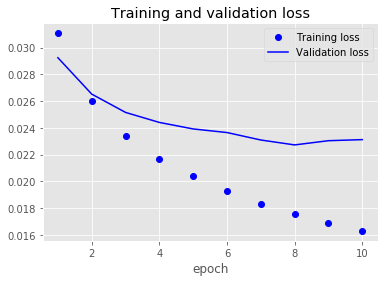

In [171]:
# run this cell to show your results #
plot_training_history(history_gru_improved)

*Trial 2 - after we saw overfitting, reducing layers and epochs*

In [41]:
%%time
# use clear_session to start a new model #
backend.clear_session()

model_gru_improved = Sequential()
model_gru_improved.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model_gru_improved.add(Dropout(drop_rate))
model_gru_improved.add(GRU(70, return_sequences=True))  # reduced n_units from 100 to 70
model_gru_improved.add(TimeDistributed(Dense(n_tags, activation='softmax')))
model_gru_improved.compile(optimizer=optimizer, loss=loss, metrics=metrics)

CPU times: user 676 ms, sys: 12 ms, total: 688 ms
Wall time: 489 ms


In [56]:
print(model_gru_improved.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 70)           25410     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1278      
Total params: 1,785,638
Trainable params: 1,785,638
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
%%time
# reducing epochs to 5
# Train model
history_gru_improved1 = model_gru_improved.fit(X_tr_bal, y_tr_bal_cat, batch_size=batch_size, epochs=5, verbose=verbose,
                                             validation_split=validation_split)

Train on 45772 samples, validate on 5086 samples
Epoch 1/5
45772/45772 [==============================] - 203s 4ms/step - loss: 0.1029 - acc: 0.9749 - val_loss: 0.0387 - val_acc: 0.9889
Epoch 2/5
45772/45772 [==============================] - 202s 4ms/step - loss: 0.0321 - acc: 0.9906 - val_loss: 0.0306 - val_acc: 0.9908
Epoch 3/5
45772/45772 [==============================] - 202s 4ms/step - loss: 0.0268 - acc: 0.9920 - val_loss: 0.0279 - val_acc: 0.9915
Epoch 4/5
45772/45772 [==============================] - 202s 4ms/step - loss: 0.0242 - acc: 0.9927 - val_loss: 0.0266 - val_acc: 0.9919
Epoch 5/5
45772/45772 [==============================] - 202s 4ms/step - loss: 0.0225 - acc: 0.9932 - val_loss: 0.0260 - val_acc: 0.9921
CPU times: user 30min 37s, sys: 2min 17s, total: 32min 54s
Wall time: 16min 52s


In [43]:
# Final evaluation of the model
scores = model_gru_improved.evaluate(X_te_bal, y_te_bal_cat)
print("Accuracy: %.2f%%" % (scores[1]*100))

5651/5651 [==============================] - 11s 2ms/step
Accuracy: 99.25%


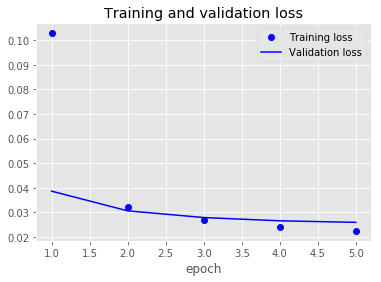

In [44]:
# run this cell to show your results #
plot_training_history(history_gru_improved1)

In [45]:
# save your model and load your model#
store_keras_model(model_gru_improved, 'model_GRU_Improved')
GRU_improved1=load_keras_model('model_GRU_Improved')

# predict on X for model Bidirectional GRU
y_pred = to_categorical(GRU_improved1.predict_classes(X_te_bal)).reshape(-1,18)
y_test = y_te_bal_cat.reshape(-1,18)
# compute f1 score for  GRU model
f1_lst = f1_score(y_test, y_pred, average=None)
f1_lst = [np.round(elem,2) for elem in f1_lst]
print(f1_lst)

Saved model to disk
[0.93, 0.91, 0.85, 0.93, 0.84, 0.68, 0.86, 0.87, 0.96, 0.95, 0.79, 0.84, 0.88, 0.78, 0.88, 0.79, 0.99, 1.0]


Comparison of f1 scores for various tags on GRU model. "INITIAL" represents our model with initial given hyperparameters.
"FIRST TRY" represents our model where we upsampled minority class our data and trained the model with given hyperparameters.
"SECOND TRY" represents our model where we changed hyperparameters like epochs, and changed structure of NN by reducing n_units in our GRU model and thus reduced overfitting. We have maintained our undersampling of minority class.

#INITIAL: [0.09, 0.33, 0.85, 0.95, 0.48, 0.67, 0.82, 0.86, 0.09, 0.10, 0.79, 0.75, 0.40, 0.76, 0.86, 0.73, 0.99, 1.0]
#FIRST TRY: [0.96, 0.96, 0.86, 0.94, 0.94, 0.7, 0.83, 0.89, 0.99, 0.98, 0.8, 0.93, 0.96, 0.79, 0.87, 0.8, 0.99, 1.0] 
#SECOND TRY:[0.93, 0.91, 0.85, 0.93, 0.84, 0.68, 0.86, 0.87, 0.96, 0.95, 0.79, 0.84, 0.88, 0.78, 0.88, 0.79, 0.99, 1.0]

We conclude with increased performance prediction using GRU model as our best model.